In [1]:
import time
import json
from multiprocessing import Pool

from IPython.display import display

from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from itertools import cycle
lstyle = cycle(('-', '--', ':', '-.',\
    (0, (1, 10)), (0, (5, 10)),\
    (0, (5, 5)), (0, (3, 10, 1, 10)),\
    (0, (3, 5, 1, 5)), \
    (0, (3, 5, 1, 5, 1, 5))))
color = cycle(('#1f77b4', '#ff7f0e', '#2ca02c',\
    '#d62728', '#9467bd', '#8c564b', '#e377c2',\
    '#7f7f7f', '#bcbd22', '#17becf'))


from scipy.sparse import *
from scipy.sparse.linalg import spsolve

**Taylor decaying**

This is a classical Navier-Stokes problem, in general used to state the con-
vergence order of the considered formulae. Exact solution is
\begin{equation} \label{eq1}
\left\lbrace 
\begin{array}{l}
 u = -e^{-2t/\mathrm{Re}} \cos(x) \sin(y) ,\\
 v =  e^{-2t/\mathrm{Re}} \sin(x) \cos(y) ,\\
 p = -e^{-4t/\mathrm{Re}} (\cos(2x) + \cos(2y))/4 ,
\end{array}
\right. 
\end{equation} 
in $[0, 2\pi]\times[0, 2\pi]\times[0, 1]$, where the Reynolds number $\mathrm{Re} = 10^{2}$, 
$\tau=0.05h$.

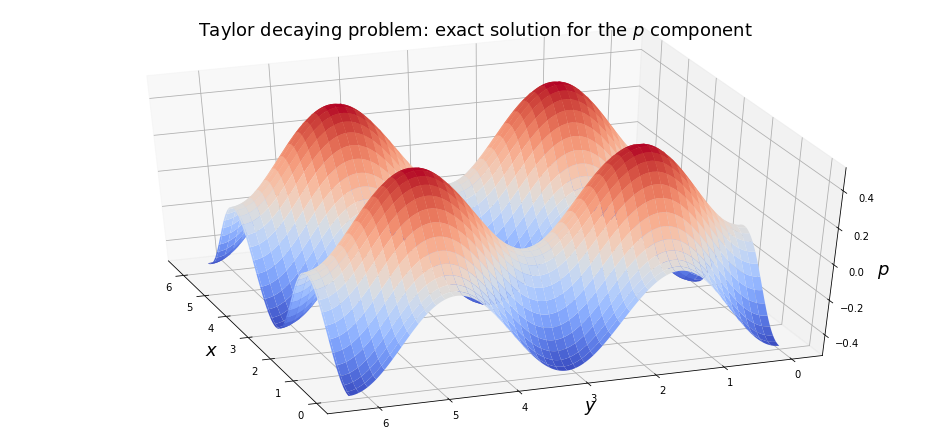

In [2]:
def taylor_decaying(t, x, y, Re):
    return (-exp(-2.*t/Re)*cos(x)*sin(y),
             exp(-2.*t/Re)*sin(x)*cos(y),
            -exp(-4.*t/Re)*(cos(2.*x)+cos(2.*y))/4.)

h, Re = 2.5e-2, 1.e2
x, y = meshgrid(arange(0., 2.*pi, h, dtype=float64),\
                arange(0., 2.*pi, h, dtype=float64), indexing='ij')

fig = figure(figsize=(13, 6))
axes = Axes3D(fig)
axes.plot_surface(x, y, taylor_decaying(0., x, y, Re)[2], \
                  rstride=5, cstride=5, cmap=cm.coolwarm)
axes.set_xlabel(r"$x$", {'fontsize': 18})
axes.set_ylabel(r"$y$", {'fontsize': 18})
axes.set_zlabel(r"$p$", {'fontsize': 18})
axes.set_title(r"Taylor decaying problem: exact solution for the $p$ component",\
               {'fontsize': 18})
axes.view_init(azim=160., elev=40.)
show()
# savefig('./taylor_decaying_exact_p.pdf')
close()


In [3]:
def A_cross1(Nx, Ny):
    Nxy = Nx*Ny
    def jk(j, k):
        return j*Ny+k
    
    row = empty((Nx, Ny, 5), dtype=int)
    for j in range(Nx):
        for k in range(Ny):
            row[j, k] = jk(j, k)

    col = zeros((Nx, Ny, 5), dtype=int)
    for j in range(1, Nx-1):
        for k in range(1, Ny-1):
            col[j, k] =             jk(j-1, k),\
                        jk(j, k-1), jk(j, k), jk(j, k+1),\
                                    jk(j+1, k)
    for j in range(Nx):
        col[j, 0, 0] = jk(j, 0)
        col[j, -1, 0] = jk(j, Ny-1)
    for k in range(1, Ny-1):
        col[0, k, 0]  = jk(0, k)
        col[-1, k, 0] = jk(Nx-1, k)

    data = zeros((Nx, Ny, 5), dtype=float64)
    data[1:-1, 1:-1] =      1.,\
                       1., -4.,  1.,\
                            1.
    data[:, 0, 0] = 1.
    data[:, -1, 0] = 1.
    data[0, 1:-1, 0] = 1.
    data[-1, 1:-1, 0] = 1.

    A = csr_matrix((data.reshape(Nxy*5),\
                    (row.reshape(Nxy*5), col.reshape(Nxy*5))),\
                   shape=(Nxy, Nxy))
    return A

def solve_1(A, b):
    Nx, Ny = b.shape
    u = spsolve(A, b.reshape(Nx*Ny)).reshape(Nx,Ny)
    return u

In [4]:
def A_cross2(Nx, Ny):
    Nxy = Nx*Ny
    def jk(j, k):
        return j*Ny+k
    
    row = empty((Nx, Ny, 5), dtype=int)
    for j in range(Nx):
        for k in range(Ny):
            row[j, k] = jk(j, k)

    col = zeros((Nx, Ny, 5), dtype=int)
    for j in range(2, Nx-2):
        for k in range(2, Ny-2):
            col[j, k] =             jk(j-2, k),\
                        jk(j, k-2), jk(j, k), jk(j, k+2),\
                                    jk(j+2, k)
    for j in range(Nx):
        col[j, 0, 0] = jk(j, 0)
        col[j, 1, 0] = jk(j, 1)
        col[j, -2, 0] = jk(j, Ny-2)
        col[j, -1, 0] = jk(j, Ny-1)
    for k in range(1, Ny-1):
        col[0, k, 0]  = jk(0, k)
        col[1, k, 0]  = jk(1, k)
        col[-2, k, 0] = jk(Nx-2, k)
        col[-1, k, 0] = jk(Nx-1, k)

    data = zeros((Nx, Ny, 5), dtype=float64)
    data[2:-2, 2:-2] =      1.,\
                       1., -4.,  1.,\
                            1.
    data[:, :2, 0] = 1.
    data[:, -2:, 0] = 1.
    data[:2, 1:-1, 0] = 1.
    data[-2:, 1:-1, 0] = 1.

    A = csr_matrix((data.reshape(Nxy*5),\
                    (row.reshape(Nxy*5), col.reshape(Nxy*5))),\
                   shape=(Nxy, Nxy))
    return A

def solve_2(A, b):
    Nx, Ny = b.shape
    u = spsolve(A, b.reshape(Nx*Ny)).reshape(Nx,Ny)
    return u

$
\operatorname{D_i} = \dfrac{\sigma_i - \sigma_i^{-1}}{2h}, \ 
\operatorname{D_t} = \dfrac{\sigma_t - 1}{\tau}, \ 
\tilde{\Delta} = \dfrac{\sigma_1 + \sigma_2 - 4 + \sigma_1^{-1} + \sigma_2^{-1}}{h^2}
$

In [5]:
def Dx(a):
    return a[2:,1:-1] - a[:-2,1:-1]
def Dy(a):
    return a[1:-1,2:] - a[1:-1,:-2]

def DD(a):
    return a[2:,1:-1] + a[1:-1,2:] +\
       -4.*a[1:-1,1:-1] +\
           a[:-2,1:-1] +a[1:-1,:-2]
def Dxx(a):
    return a[4:,2:-2] - 2.*a[2:-2,2:-2] + a[:-4,2:-2]
def Dxy(a):
    return a[3:-1,3:-1] - a[3:-1,1:-3] - a[1:-3,3:-1] + a[1:-3,1:-3]
def Dyy(a):
    return a[2:-2,4:] - 2.*a[2:-2,2:-2] + a[2:-2,:-4]

def DDx(a):
    return (a[4:,2:-2] + a[3:-1,3:-1] -\
            4.*a[3:-1,2:-2] + a[3:-1,1:-3]) -\
           (a[1:-3,3:-1] - 4.*a[1:-3,2:-2] +\
            a[:-4,2:-2] + a[1:-3,1:-3])
def DDy(a):
    return (a[3:-1,3:-1] + a[2:-2,4:] -\
            4.*a[2:-2,3:-1] + a[1:-3,3:-1]) -\
           (a[3:-1,1:-3] - 4.*a[2:-2,1:-3] +\
            a[1:-3,1:-3] + a[2:-2,:-4])

**FDA1**


Amodio Pierluigi, Blinkov Yuri, Gerdt Vladimir, La Scala Roberto Algebraic construction and numerical behavior of a new s-consistent difference scheme for the 2D Navier–Stokes equations. Applied Mathematics and Computation, 2017, vol. 314, pp. 408-421. DOI: 10.1016/j.amc.2017.06.037 Available at: http://www.sciencedirect.com/science/article/pii/S0096300317304502

page 415

\begin{equation}
\left\lbrace 
\begin{array}{rl}
F^1:& \operatorname{D_1}(u) + \operatorname{D_2}(v)=0 ,\\[4pt]
F^2:& \operatorname{D_t}(u) + \operatorname{D_1}(u^2)+
\operatorname{D_2}(vu) + 
\operatorname{D_1}(p) - \frac{1}{\mathrm{Re}} \tilde{\Delta} (u)
=0 ,\\[4pt]
F^3:& \operatorname{D_t}(v) + \operatorname{D_1}(uv)+
\operatorname{D_2}(v^2) +
\operatorname{D_2}(p) - \frac{1}{\mathrm{Re}} \tilde{\Delta} (v)
=0 ,\\[4pt]
F^4:& \left(\operatorname{D_1}^2 + \operatorname{D_2}^2\right)(p) + \operatorname{D_1}^2(u^2) + \operatorname{D_2}^2(v^2) + 2\operatorname{D_1}\operatorname{D_2}(uv)
- \frac{1}{\mathrm{Re}}\tilde{\Delta}(F^1)
=0 .
\end{array}
\right. 
\end{equation}

In [6]:
def FDA1(A, S, F, BC, tau, h, Re):
    u, v, p = F
    left, top, right, bottom = BC
    u1, v1, p1 = empty_like(u), empty_like(v), empty_like(p)

    u1[0, :],  v1[0, :],  p1[:2, :] = left
    u1[:, -1], v1[:, -1], p1[:, -2:] = top
    u1[-1, :], v1[-1, :], p1[-2:, :] = right
    u1[:, 0],  v1[:, 0],  p1[:, :2] = bottom
    
    u1[1:-1,1:-1] = u[1:-1,1:-1]-tau/h*(\
        Dx(u**2)/2. + Dy(v*u)/2. + Dx(p)/2. - DD(u)/(h*Re))

    v1[1:-1,1:-1] = v[1:-1,1:-1]-tau/h*(\
        Dx(u*v)/2. + Dy(v**2)/2. + Dy(p)/2. - DD(v)/(h*Re))

    p1[2:-2,2:-2] = -(\
        Dxx(u1**2) + Dyy(v1**2) + 2.*Dxy(u1*v1) -\
        2./(h*Re)*(DDx(u1) + DDy(v1)))
    
    p1 = S(A, p1)

    return u1, v1, p1

**FDA2**

Hans Johnston and Jian-Guo Liu, Finite Difference Schemes for Incompressible Flow Based on Local Pressure Boundary Conditions. Journal of Computational Physics 180, 120–154 (2002) doi:10.1006/jcph.2002.7079

page 126

\begin{equation}
\left\lbrace 
\begin{array}{rl}
F^1:& \operatorname{D_1}(u) + \operatorname{D_2}(v)=0 ,\\[4pt]
F^2:& \operatorname{D_t}(u) + u\operatorname{D_1}(u)+
v\operatorname{D_2}(u) + 
\operatorname{D_1}(p) - \frac{1}{\mathrm{Re}} \tilde{\Delta} (u)
=0 ,\\[4pt]
F^3:& \operatorname{D_t}(v) + u\operatorname{D_1}(v)+
v\operatorname{D_2}(v) +
\operatorname{D_2}(p) - \frac{1}{\mathrm{Re}} \tilde{\Delta} (v)
=0 ,\\[4pt]
F^4:& \tilde{\Delta}(p) 
- 2\operatorname{D_1}(u)\operatorname{D_2}(v)
+ 2\operatorname{D_1}(v)\operatorname{D_2}(u)
=0 .
\end{array}
\right. 
\end{equation}

In [7]:
def FDA2(A, S, F, BC, tau, h, Re):
    u, v, p = F
    left, top, right, bottom = BC
    u1, v1, p1 = empty_like(u), empty_like(v), empty_like(p)

    u1[0, :],  v1[0, :],  p1[0, :] = left
    u1[:, -1], v1[:, -1], p1[:, -1] = top
    u1[-1, :], v1[-1, :], p1[-1, :] = right
    u1[:, 0],  v1[:, 0],  p1[:, 0] = bottom
    
    u1[1:-1,1:-1] = u[1:-1,1:-1]-tau/h*(\
        u[1:-1,1:-1]*Dx(u)/2. + v[1:-1,1:-1]*Dy(u)/2. + Dx(p)/2. - DD(u)/(h*Re))

    v1[1:-1,1:-1] = v[1:-1,1:-1]-tau/h*(\
        u[1:-1,1:-1]*Dx(v)/2. + v[1:-1,1:-1]*Dy(v)/2. + Dy(p)/2. - DD(v)/(h*Re))

    p1[1:-1,1:-1] = (\
        Dx(u1)*Dy(v1) - Dy(u1)*Dx(v1))/2.
    
    p1 = S(A, p1)

    return u1, v1, p1

**FDA3**


Amodio Pierluigi, Blinkov Yuri, Gerdt Vladimir, La Scala Roberto Algebraic construction and numerical behavior of a new s-consistent difference scheme for the 2D Navier–Stokes equations. Applied Mathematics and Computation, 2017, vol. 314, pp. 408-421. DOI: 10.1016/j.amc.2017.06.037 Available at: http://www.sciencedirect.com/science/article/pii/S0096300317304502

page 417

\begin{equation}
\left\lbrace 
\begin{array}{rl}
F^1:& \operatorname{D_1}(u) + \operatorname{D_2}(v)=0 ,\\[4pt]
F^2:& \operatorname{D_t}(u) + \operatorname{D_1}(u^2)+
\operatorname{D_2}(vu) + 
\operatorname{D_1}(p) - \frac{1}{\mathrm{Re}} \tilde{\Delta} (u)
=0 ,\\[4pt]
F^3:& \operatorname{D_t}(v) + \operatorname{D_1}(uv)+
\operatorname{D_2}(v^2) +
\operatorname{D_2}(p) - \frac{1}{\mathrm{Re}} \tilde{\Delta} (v)
=0 ,\\[4pt]
F^4:& \left(\operatorname{D_1}^2 + \operatorname{D_2}^2\right)(p) + \operatorname{D_1}^2(u^2) + \operatorname{D_2}^2(v^2) + {} \\
&{} + 2\operatorname{D_1}\operatorname{D_2}(uv)
=0 .
\end{array}
\right. 
\end{equation}

In [8]:
def FDA3(A, S, F, BC, tau, h, Re):
    u, v, p = F
    left, top, right, bottom = BC
    u1, v1, p1 = empty_like(u), empty_like(v), empty_like(p)

    u1[0, :],  v1[0, :],  p1[:2, :] = left
    u1[:, -1], v1[:, -1], p1[:, -2:] = top
    u1[-1, :], v1[-1, :], p1[-2:, :] = right
    u1[:, 0],  v1[:, 0],  p1[:, :2] = bottom
    
    u1[1:-1,1:-1] = u[1:-1,1:-1]-tau/h*(\
        Dx(u**2)/2. + Dy(v*u)/2. + Dx(p)/2. - DD(u)/(h*Re))

    v1[1:-1,1:-1] = v[1:-1,1:-1]-tau/h*(\
        Dx(u*v)/2. + Dy(v**2)/2. + Dy(p)/2. - DD(v)/(h*Re))

    p1[2:-2,2:-2] = -(\
        Dxx(u1**2) + Dyy(v1**2) + 2.*Dxy(u1*v1))
    
    p1 = S(A, p1)

    return u1, v1, p1

**FDA4**

\begin{equation}
\left\lbrace 
\begin{array}{rl}
F^1:& \operatorname{D_1}(u) + \operatorname{D_2}(v)=0 ,\\[4pt]
F^2:& \operatorname{D_t}(u) + u\operatorname{D_1}(u)+
v\operatorname{D_2}(u) + 
\operatorname{D_1}(p) - \frac{1}{\mathrm{Re}} \tilde{\Delta} (u)
=0 ,\\[4pt]
F^3:& \operatorname{D_t}(v) + u\operatorname{D_1}(v)+
v\operatorname{D_2}(v) +
\operatorname{D_2}(p) - \frac{1}{\mathrm{Re}} \tilde{\Delta} (v)
=0 ,\\[4pt]
F^4:& \left(\operatorname{D_1}^2 + \operatorname{D_2}^2\right)(p) 
    + \operatorname{D_1}(u\operatorname{D_1}(u))
    + \operatorname{D_2}(v\operatorname{D_2}(v)) + {} \\
&{} +  \operatorname{D_1}(v\operatorname{D_2}(u))
    + \operatorname{D_2}(u\operatorname{D_1}(v))
- \frac{1}{\mathrm{Re}}\tilde{\Delta}(F^1)
=0 .
\end{array}
\right. 
\end{equation}

In [9]:
def FDA4(A, S, F, BC, tau, h, Re):
    u, v, p = F
    left, top, right, bottom = BC
    u1, v1, p1 = empty_like(u), empty_like(v), empty_like(p)

    u1[0, :],  v1[0, :],  p1[:2, :] = left
    u1[:, -1], v1[:, -1], p1[:, -2:] = top
    u1[-1, :], v1[-1, :], p1[-2:, :] = right
    u1[:, 0],  v1[:, 0],  p1[:, :2] = bottom
    
    u1[1:-1,1:-1] = u[1:-1,1:-1]-tau/h*(\
        u[1:-1,1:-1]*Dx(u)/2. + v[1:-1,1:-1]*Dy(u)/2. + Dx(p)/2. - DD(u)/(h*Re))

    v1[1:-1,1:-1] = v[1:-1,1:-1]-tau/h*(\
        u[1:-1,1:-1]*Dx(v)/2. + v[1:-1,1:-1]*Dy(v)/2. + Dy(p)/2. - DD(v)/(h*Re))

    p1[2:-2,2:-2] = -(\
        Dx(u1[1:-1,1:-1]*Dx(u1)) + Dy(v1[1:-1,1:-1]*Dy(v1)) +\
        Dx(v1[1:-1,1:-1]*Dy(u1)) + Dy(u1[1:-1,1:-1]*Dx(v1)) -\
        2./(h*Re)*(DDx(u1) + DDy(v1)))
    
    p1 = S(A, p1)

    return u1, v1, p1

In [10]:
fda = (FDA1, FDA2, FDA3, FDA4)

In [11]:
def error(f, g):
    return max((abs(f - g)/(1. + abs(g))).flat)

def div(u, v, h):
    return norm(Dx(u[1:-1,1:-1])/(2*h) + Dy(v[1:-1,1:-1])/(2*h))
    
def sol(args):
    exact, x, y, t1, fda, h, tau, Re = args
    FDA = str(fda).split(' ')[1]
    print(FDA, "h =", h, "begin")
    err = zeros((5, (int(ceil(t1/tau)))), dtype=float64)
    if FDA == 'FDA2':
        A = A_cross1(x.shape[0], x.shape[1])
    else:
        A = A_cross2(x.shape[0], x.shape[1])
    t = 0.
    u1, v1, p1 = exact(t, x, y, Re)
    for n in range(err.shape[1]):
        t += tau
        u, v, p = exact(t, x, y, Re)
        left   = u[0, :],  v[0, :],  p[0, :]  if FDA == 'FDA2' else p[:2, :] 
        top    = u[:, -1], v[:, -1], p[:, -1] if FDA == 'FDA2' else p[:, -2:] 
        right  = u[-1, :], v[-1, :], p[-1, :] if FDA == 'FDA2' else p[-2:, :] 
        bottom = u[:, 0],  v[:, 0],  p[:, 0]  if FDA == 'FDA2' else p[:, :2] 

        u1, v1, p1 = fda(A, solve_1 if FDA == 'FDA2' else solve_2,\
                    (u1, v1, p1), (left, top, right, bottom), tau, h, Re)

        err[:, n] = t, error(u, u1), error(v, v1), error(p, p1),  div(u1, v1, h)

        if max(err[1:, n]) > 1.e1:
            break
    print(FDA, "h =", h, " end")
    return (args, n, err)

# Taylor decaying

In [12]:
tasks = []
for m in range(-1, 3):
    h = 0.1/2**m
    tau = 0.05*h
    print("h =", h, "  steps =", int(ceil(1.0/tau)))
    x, y = meshgrid(arange(0., 2.*pi, h, dtype=float64),\
                    arange(0., 2.*pi, h, dtype=float64), indexing='ij')

    for f in fda:
        args = taylor_decaying, x, y, 6.0, f, h, tau, 100.
        tasks.append(args)
len(tasks)

h = 0.2   steps = 100
h = 0.1   steps = 200
h = 0.05   steps = 400
h = 0.025   steps = 800


16

In [13]:
proc = 6
clock = time.perf_counter()
pool = Pool(processes=proc)
res = pool.map_async(sol, tasks)
pool.close()
pool.join()
res_taylor_decaying = res.get()
print("Time: %.3f * %d" % (time.perf_counter() - clock, proc))

FDA1 h = 0.2 begin
FDA2 h = 0.2 begin
FDA4 h = 0.2 begin
FDA2 h = 0.1 begin
FDA3 h = 0.2 begin
FDA1 h = 0.1 begin
FDA4 h = 0.2  end
FDA3 h = 0.1 begin
FDA3 h = 0.2  end
FDA4 h = 0.1 begin
FDA1 h = 0.2  end
FDA1 h = 0.05 begin
FDA2 h = 0.2  end
FDA2 h = 0.05 begin
FDA1 h = 0.1  end
FDA3 h = 0.05 begin
FDA3 h = 0.1  end
FDA4 h = 0.05 begin
FDA4 h = 0.1  end
FDA1 h = 0.025 begin
FDA2 h = 0.1  end
FDA2 h = 0.025 begin
FDA1 h = 0.05  end
FDA3 h = 0.025 begin
FDA4 h = 0.05  end
FDA4 h = 0.025 begin
FDA3 h = 0.05  end
FDA2 h = 0.05  end
FDA3 h = 0.025  end
FDA1 h = 0.025  end
FDA4 h = 0.025  end
FDA2 h = 0.025  end
Time: 4979.606 * 6


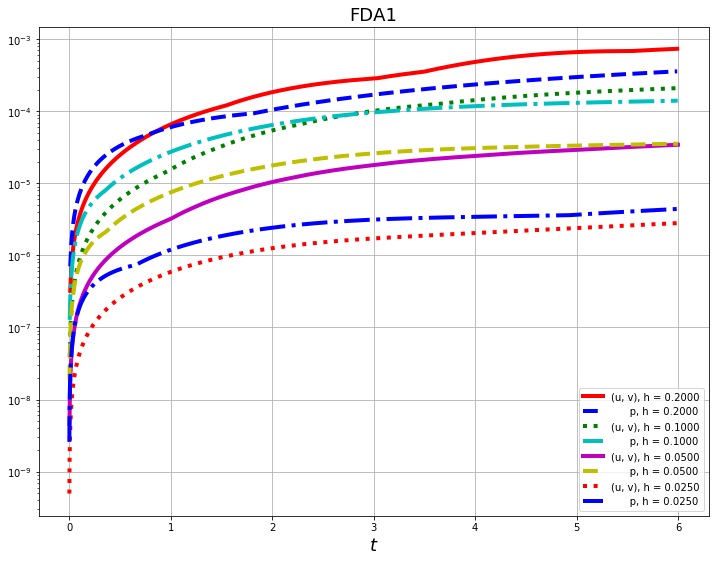

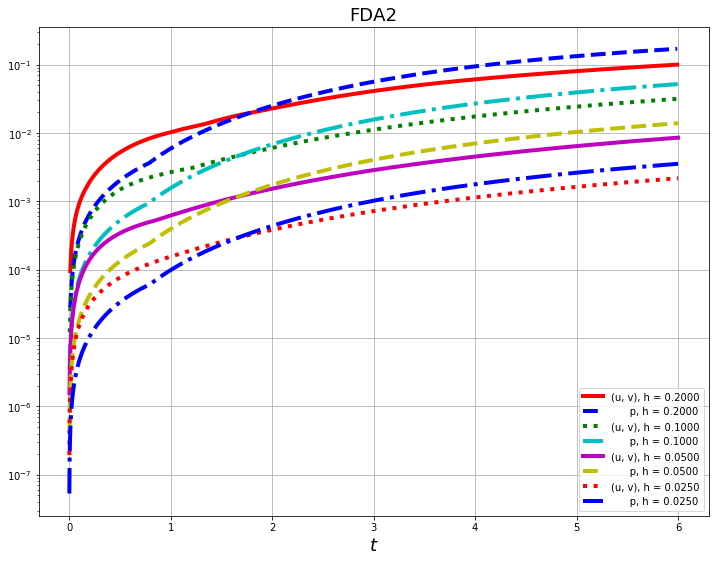

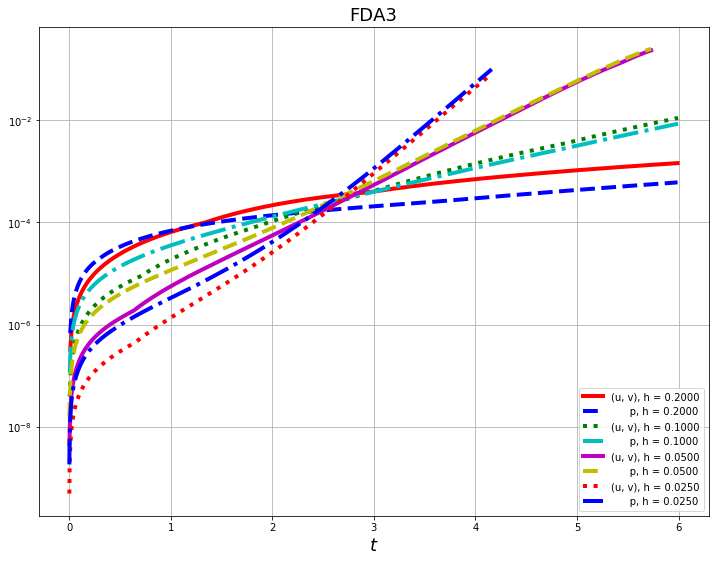

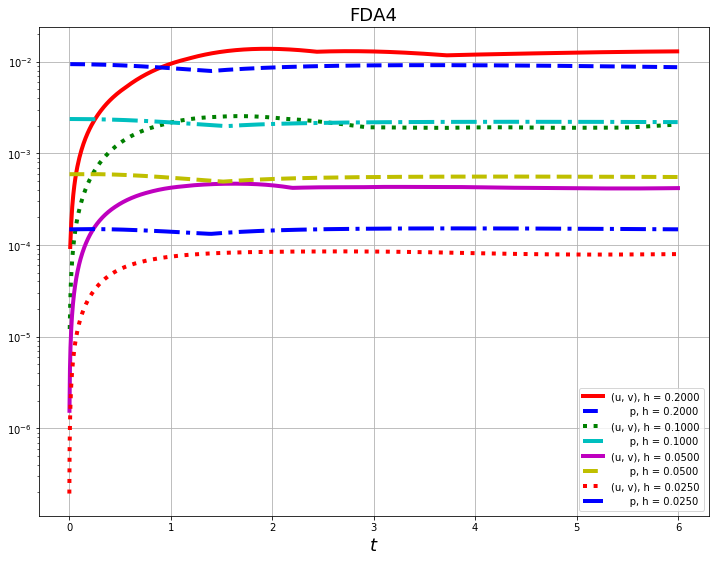

In [14]:
l = ['(u, v)', 'v', '      p', 'div']
for f in fda:
    lstyle = cycle(('-', '--', ':', '-.'))
    color = cycle('rbgcmy')
    res = sorted((r for r in res_taylor_decaying if r[0][4] == f),\
                 key=lambda r: -r[0][5])
    figure(figsize=(12, 9))
    title(str(f).split(' ')[1], {'fontsize': 18})
    for r in res:
        for k in [0, 2]:
            semilogy(r[2][0][:r[1]],\
                     r[2][k+1][:r[1]],\
                     label="%s, h = %.4f" % (l[k], r[0][5]),
                     linestyle=next(lstyle),
                     color=next(color),
                     linewidth=4)
    xlabel(r'$t$', {'fontsize': 18})
#     ylim((10**-15, 10**1))
    grid()
    legend(loc='lower right', fancybox=True)
#     savefig("taylor_decaying_%s.pdf" % str(f).split(' ')[1])
    show()
    close()

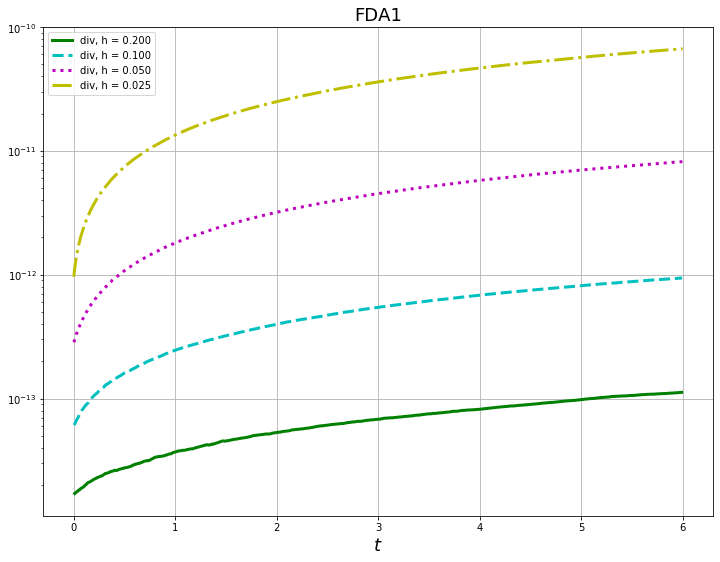

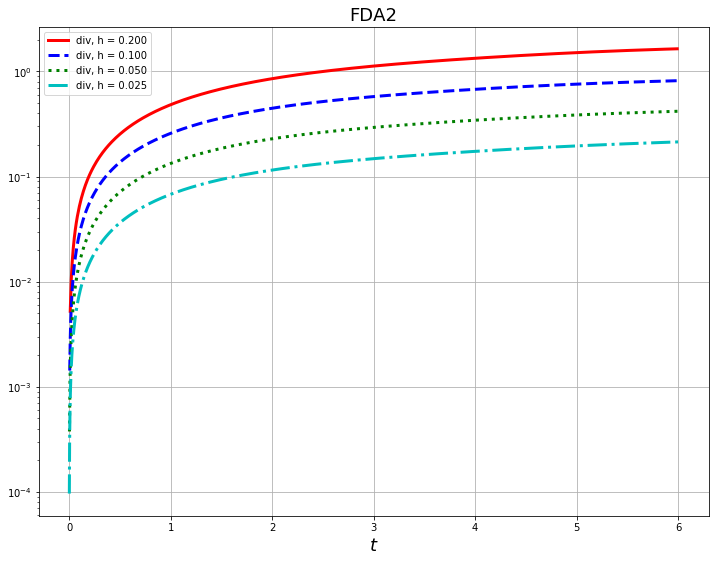

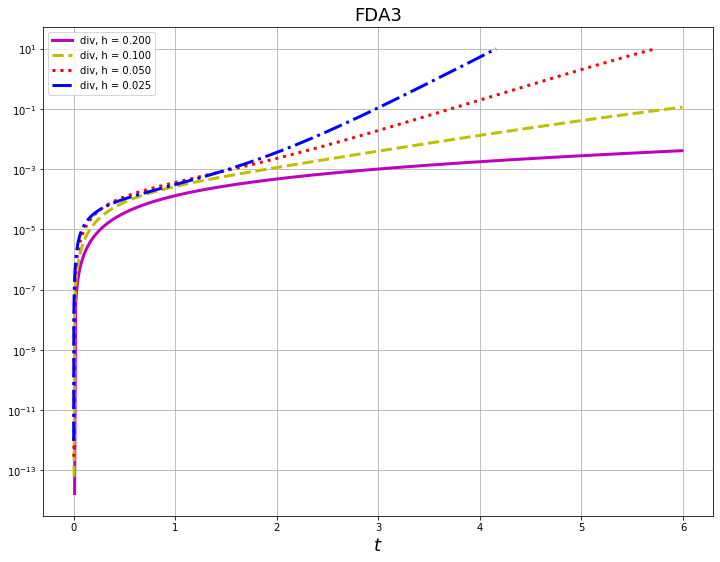

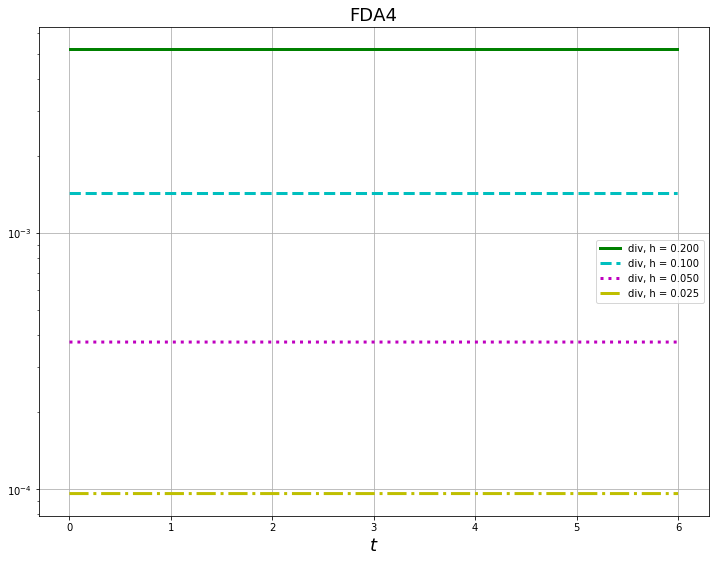

In [15]:
l = ['u', 'v', 'p', 'div']
for f in fda:
    res = sorted((r for r in res_taylor_decaying if r[0][4] == f),\
                 key=lambda r: -r[0][5])
    figure(figsize=(12, 9))
    title(str(f).split(' ')[1], {'fontsize': 18})
    for r in res:
        for k in [3]:
            semilogy(r[2][0][:r[1]],\
                     r[2][k+1][:r[1]],\
                     label="%s, h = %.3f" % (l[k], r[0][5]),
                     linestyle=next(lstyle),
                     color=next(color),
                     linewidth=3)
    xlabel(r'$t$', {'fontsize': 18})
#     ylim((10**-15, 10**1))
    grid()
    legend(loc='best', fancybox=True)
    show()
    close()

In [16]:
def tbl(res):
    print(r"""\begin{center}
%s

\begin{tabular}{rrrrrr}\hline
\multicolumn{1}{c}{h} &
\multicolumn{1}{c}{t} &
\multicolumn{1}{c}{Error in u} &
\multicolumn{1}{c}{Error in v} &
\multicolumn{1}{c}{Error in p} &
\multicolumn{1}{c}{Error in div} \\ \hline""" % res[0])
    for l in res[1:]:
        print(r' {:.2e} & {:.2f} & {:.2e} & {:.2e} & {:.2e} & {:.2e} \\'.format(*l))
    print(r"""\hline
\end{tabular}
\end{center}
""")

In [17]:
t = []
for f in fda:
    t.append([str(f).split(' ')[1]])
    res = sorted((r for r in res_taylor_decaying if r[0][4] == f),\
                 key=lambda r: -r[0][5])
    for r in res:
        t[-1].append([r[0][5], r[2][0][r[1]-1]])
        for k in range(4):
            t[-1][-1].append(r[2][k+1][r[1]-1])

In [18]:
for l in t:
    tbl(l)

\begin{center}
FDA1

\begin{tabular}{rrrrrr}\hline
\multicolumn{1}{c}{h} &
\multicolumn{1}{c}{t} &
\multicolumn{1}{c}{Error in u} &
\multicolumn{1}{c}{Error in v} &
\multicolumn{1}{c}{Error in p} &
\multicolumn{1}{c}{Error in div} \\ \hline
 2.00e-01 & 5.99 & 7.38e-04 & 7.27e-04 & 3.59e-04 & 1.12e-13 \\
 1.00e-01 & 5.99 & 2.10e-04 & 2.17e-04 & 1.41e-04 & 9.40e-13 \\
 5.00e-02 & 6.00 & 3.44e-05 & 3.47e-05 & 3.55e-05 & 8.17e-12 \\
 2.50e-02 & 6.00 & 2.81e-06 & 2.82e-06 & 4.42e-06 & 6.67e-11 \\
\hline
\end{tabular}
\end{center}

\begin{center}
FDA2

\begin{tabular}{rrrrrr}\hline
\multicolumn{1}{c}{h} &
\multicolumn{1}{c}{t} &
\multicolumn{1}{c}{Error in u} &
\multicolumn{1}{c}{Error in v} &
\multicolumn{1}{c}{Error in p} &
\multicolumn{1}{c}{Error in div} \\ \hline
 2.00e-01 & 5.99 & 9.99e-02 & 1.00e-01 & 1.70e-01 & 1.64e+00 \\
 1.00e-01 & 5.99 & 3.16e-02 & 3.16e-02 & 5.19e-02 & 8.17e-01 \\
 5.00e-02 & 6.00 & 8.53e-03 & 8.53e-03 & 1.39e-02 & 4.18e-01 \\
 2.50e-02 & 6.00 & 2.18e-03 & 2.18e

In [19]:
for f in fda:
    res = sorted((r for r in res_taylor_decaying if r[0][4] == f),\
                 key=lambda r: -r[0][5])
    with open('2D-%s.json' % str(f).split(' ')[1], 'w') as f:
        data = {}
        for args, n, err in res:
            data[args[5]] = [n, err.tolist()]
        json.dump(data, f)